In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Download crop disease dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantvillage-dataset' dataset.
Path to dataset files: /kaggle/input/plantvillage-dataset


## Importing the required libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Data Preprocessing

### Removing images which are out of scope

In [ ]:
import os
import shutil

source_dir = "/kaggle/input/plantvillage-dataset/plantvillage dataset/color/"

dest_dir = "/kaggle/working/plantvillage_dataset/"

classes_out_of_scope = [
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Raspberry___healthy",
    "Soybean___healthy"
]

os.makedirs(dest_dir, exist_ok=True)

for class_name in os.listdir(source_dir):
    src_path = os.path.join(source_dir, class_name)
    dst_path = os.path.join(dest_dir, class_name)

    if os.path.isdir(src_path) and class_name not in classes_out_of_scope:
        shutil.copytree(src_path, dst_path)
        print(f"Copied: {class_name}")
    else:
        print(f"Skipped: {class_name}")


Copied: Tomato___Late_blight
Copied: Tomato___healthy
Copied: Grape___healthy
Skipped: Orange___Haunglongbing_(Citrus_greening)
Skipped: Soybean___healthy
Copied: Squash___Powdery_mildew
Copied: Potato___healthy
Copied: Corn_(maize)___Northern_Leaf_Blight
Copied: Tomato___Early_blight
Copied: Tomato___Septoria_leaf_spot
Copied: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Copied: Strawberry___Leaf_scorch
Skipped: Peach___healthy
Copied: Apple___Apple_scab
Copied: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Copied: Tomato___Bacterial_spot
Copied: Apple___Black_rot
Skipped: Blueberry___healthy
Skipped: Cherry_(including_sour)___Powdery_mildew
Skipped: Peach___Bacterial_spot
Copied: Apple___Cedar_apple_rust
Copied: Tomato___Target_Spot
Copied: Pepper,_bell___healthy
Copied: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Copied: Potato___Late_blight
Copied: Tomato___Tomato_mosaic_virus
Copied: Strawberry___healthy
Copied: Apple___healthy
Copied: Grape___Black_rot
Copied: Potato___Early_blight

In [ ]:
parent_directory = "/kaggle/working/plantvillage_dataset"

## Training and Test Dataset Loading

In [ ]:
BATCH_SIZE = 32
IMAGE_SHAPE = (128,128)

In [ ]:
# Define augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values
    rotation_range=30,           # random rotation (0-30 degrees)
    width_shift_range=0.2,       # horizontal shift
    height_shift_range=0.2,      # vertical shift
    shear_range=0.2,             # shear transformation
    zoom_range=0.2,              # zoom in/out
    horizontal_flip=True,        # randomly flip horizontally
    brightness_range=[0.4, 1.2], # random brightness
    validation_split=0.2,        # split for validation
    fill_mode='nearest',
)

# Validation set (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training set with augmentations
train_gen = train_datagen.flow_from_directory(
    parent_directory,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation set
val_gen = val_datagen.flow_from_directory(
    parent_directory,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 29827 images belonging to 30 classes.
Found 7445 images belonging to 30 classes.


In [ ]:
train_samples = train_gen.samples
val_samples = val_gen.samples
print("Number of training samples:", train_gen.samples)
print("Number of validation samples:", val_gen.samples)

Number of training samples: 29827
Number of validation samples: 7445


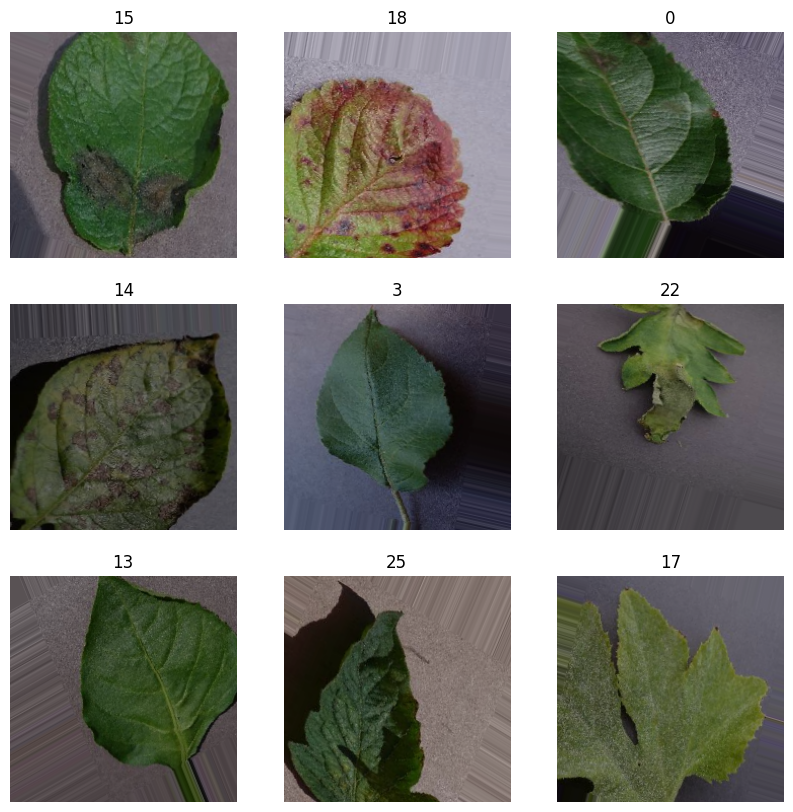

In [ ]:
import numpy as np
images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis("off")
plt.show()

# Model Building

In [ ]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[IMAGE_SHAPE[0],IMAGE_SHAPE[1],3]))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Dropout(0.25)) # To avoid Overfitting

model.add(Flatten())

model.add(Dense(units=1500,activation='relu'))

model.add(Dropout(0.4))

#Output Layer
model.add(Dense(units=30,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1500)           │     3,073,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │        45,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,830,754 (29.87 MB)

 Trainable params: 7,830,754 (29.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',   # What to monitor (val_loss or val_accuracy)
    patience=5,           # Number of epochs with no improvement before stopping
    restore_best_weights=True,
    verbose=1
)

In [ ]:
training_history = model.fit(train_gen,
                             epochs=50,
                             validation_data=val_gen,
                             callbacks=[early_stop],  # EarlyStopping
                             verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
908/933 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.1739 - loss: 2.9912

# Model Performance Analysis

1. A line plot showing training vs validation accuracy over epochs.
2. A line plot showing training vs validation loss over epochs.

In [ ]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss graph
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'training_history' is not defined